In [1]:
import numpy as np
import pickle
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight
import neat
from neat import Config, Population, DefaultGenome, DefaultReproduction, DefaultSpeciesSet, DefaultStagnation

from pureples.shared.substrate import Substrate
from pureples.shared.create_cppn import create_cppn
from pureples.es_hyperneat.es_hyperneat import ESNetwork

In [2]:
X_train = np.load('../X_train.npy')
y_train = np.load('../y_train.npy')
X_test  = np.load('../X_test.npy')
y_test  = np.load('../y_test.npy')


In [3]:
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_test, y_test)


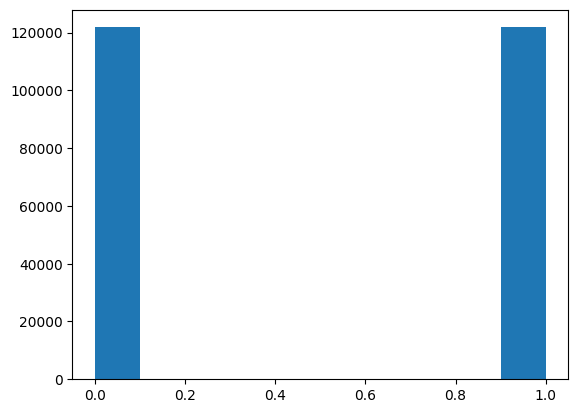

(array([121813.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,   6187.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

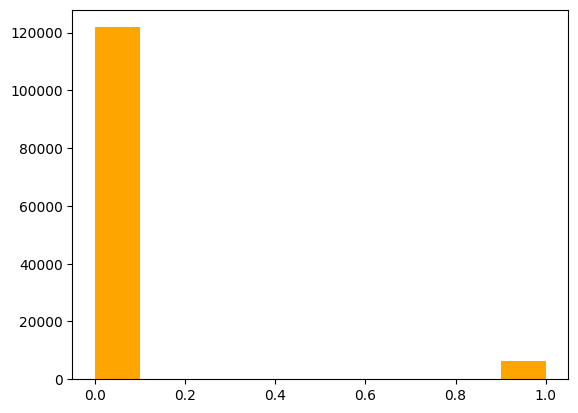

In [4]:
plt.hist(y_train)
plt.show()
plt.hist(y_test, color='orange')

In [5]:
sample_train = 20000
# X_train = X_train.
# y_train = y_train[:sample_train]
# plt.hist(y_train)
print(f"Train: {X_train.shape}, Test: {X_test.shape}")
print(y_train.shape, y_test.shape)

Train: (243626, 4), Test: (128000, 4)
(243626,) (128000,)


In [6]:
i_coords = [(-1.0, 0.5), (0.0, 0.5), (1.0, 0.5), (0.5, 1.0)] 
hidden_coords = []
o_coords = [(0.0, -1.0)]
substrate = Substrate(i_coords, o_coords, hidden_coords)

In [7]:
es_params = {
    "initial_depth": 0,      # Было 1
    "max_depth": 1,          # Было 3
    "variance_threshold": 0.03,
    "band_threshold": 0.2,
    "iteration_level": 1,
    "division_threshold": 0.3,
    "max_weight": 5.0,
    "activation": "sigmoid",
}

In [8]:
def eval_genomes(genomes, config):
    for gid, genome in genomes:
        # Проверка данных ДО создания сети
        if len(X_train[0]) != 4:
            raise ValueError(f"Ожидается 4 признака, получено {len(X_train[0])}")

        cppn = create_cppn(genome, config, "sigmoid")
        es_net = ESNetwork(substrate, cppn, es_params)
        net = es_net.create_phenotype_network()
        
        # Проверка первого элемента данных
        sample_input = X_train[0]
        # print("Размерность входных данных:", len(sample_input))  # Должно быть 4
        
        preds = [int(net.activate(x)[0] > 0) for x in X_train]

        sample_weights = compute_sample_weight('balanced', y_train)
        genome.fitness = accuracy_score(y_train, preds, sample_weight=sample_weights)


In [9]:
config_path = "es_hyper_neat.cfg"
config = Config(DefaultGenome, DefaultReproduction, DefaultSpeciesSet, DefaultStagnation, config_path)

pop = Population(config)
pop.add_reporter(neat.StdOutReporter(True))
pop.add_reporter(neat.StatisticsReporter())

winner = pop.run(eval_genomes, n=5)


 ****** Running generation 0 ****** 

Population's average fitness: 0.50000 stdev: 0.00000
Best fitness: 0.50000 - size: (1, 5) - species 1 - id 1
Average adjusted fitness: 0.000
Mean genetic distance 0.952, standard deviation 0.383
Population of 150 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0   150      0.5    0.000     0
Total extinctions: 0
Generation time: 38.997 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.50000 stdev: 0.00000
Best fitness: 0.50000 - size: (1, 5) - species 1 - id 1
Average adjusted fitness: 0.000
Mean genetic distance 1.146, standard deviation 0.457
Population of 150 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1   150      0.5    0.000     1
Total extinctions: 0
Generation time: 38.469 sec (38.733 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.50000 stdev: 0

In [10]:
with open("es_hyper_model.pkl", "wb") as f:
    pickle.dump(winner, f)

In [11]:
cppn_w = create_cppn(winner, config, output_activation_function=es_params["activation"])
es_net_w = ESNetwork(substrate, cppn_w, es_params)
net_w    = es_net_w.create_phenotype_network()

y_pred = [int(net_w.activate(x)[0] > 0.5) for x in X_test]

print("\n— Test metrics —")
print("Accuracy       :", accuracy_score(y_test, y_pred))
print("F1-score       :", f1_score(y_test, y_pred, average='weighted'))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


— Test metrics —
Accuracy       : 0.9516640625
F1-score       : 0.92809465036097

Classification report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98    121813
           1       0.00      0.00      0.00      6187

    accuracy                           0.95    128000
   macro avg       0.48      0.50      0.49    128000
weighted avg       0.91      0.95      0.93    128000

Confusion matrix:
 [[121813      0]
 [  6187      0]]


d:\Programming\CollisionML\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Programming\CollisionML\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Programming\CollisionML\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
